In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt

pd.options.mode.chained_assignment = None  # default='warn'

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import svm

## 1. Data Cleaning and Feature Engineering

#### 1.1 First clean: only take the useful columns

In [70]:
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")

In [71]:
print round3.columns
print round2.columns
print round1.columns

Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'extra_people',
       u'guests_included', u'host_acceptance_rate', u'host_id',
       u'host_is_superhost', u'host_name', u'host_response_rate',
       u'host_response_time', u'host_total_listings_count', u'host_url', u'id',
       u'instant_bookable', u'listing_url', u'minimum_nights',
       u'monthly_price', u'nightly_plus_guest_price', u'nightly_price',
       u'nightly_price_scraped', u'number_of_reviews', u'openings',
       u'percent_agreed', u'price_agreed', u'price_requested', u'response',
       u'room_type'],
      dtype='object')
Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'host_acceptance_rate',
       u'host_id', u'host_is_superhost', u'ho

In [72]:
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested"]]

print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [73]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round1_clean.head()

,id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,instant_bookable,room_type,bucket_name,discount_asked,nightly_price,decision,price_agreed,percent_agreed,calendars,price_requested
0,5557381,28811542,100%,100%,1,t,Private room,daysM_weeks1,0.7,51,0,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35
1,9147025,403032,100%,100%,1,f,Entire home/apt,days1_weeksM,0.7,134,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",90
10,2745620,1172202,100%,100%,5,t,Private room,days3_weeks1,0.9,41,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35
100,7879486,38964485,100%,92%,2,f,Entire home/apt,days2_weeks1,0.7,101,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",70
101,3557570,1594959,100%,None,1,f,Private room,daysM_weeks2,0.6,65,0,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35


In [74]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})

combined = pd.concat([round1_clean, round2_clean, round3_clean], keys=["round1", "round2", "round3"], ignore_index=False)
combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [75]:
combined.head()

,bucket_name,calendars,decision,discount_agreed,discount_asked,host_acceptance_rate,host_id,host_response_rate,host_total_listings_count,id,instant_bookable,nightly_price,percent_agreed,price_agreed,price_requested,room_type,source
0,daysM_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.7,100%,28811542,100%,1,5557381,t,51,None,NaN,35,Private room,1
1,days1_weeksM,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,100%,403032,100%,1,9147025,f,134,None,NaN,90,Entire home/apt,1
2,days3_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.9,100%,1172202,100%,5,2745620,t,41,None,NaN,35,Private room,1
3,days2_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,92%,38964485,100%,2,7879486,f,101,None,NaN,70,Entire home/apt,1
4,daysM_weeks2,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.6,None,1594959,100%,1,3557570,f,65,None,NaN,35,Private room,1


In [76]:
combined.isnull().sum()

bucket_name                    0
calendars                      0
decision                       0
discount_agreed              705
discount_asked                 0
host_acceptance_rate          56
host_id                        0
host_response_rate            20
host_total_listings_count      0
id                             0
instant_bookable               0
nightly_price                  0
percent_agreed               703
price_agreed                 573
price_requested              283
room_type                      0
source                         0
dtype: int64

#### 1.2 Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [77]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in combined["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

combined["price_median"]=calendar_median_price
combined["price_std"]=calendar_price_std/calendar_median_price
combined["orig_percent_off"]=1-combined["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [78]:
key_1m = map(str, range(30))
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in combined["calendars"].values]

combined["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [79]:
shared = combined["room_type"].values
combined["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = combined["instant_bookable"].values
combined["instant"] = [x=="t" for x in shared]
# instant_binary

In [80]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in combined["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
combined["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 1.3 Add indicators for the buckets

Construct 11 variables: 3 types of orphans, 2 types of advances, and 3x2=6 types of interactions

In [81]:
opening_attr = combined["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days1_weeks2":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days2_weeks1":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days2_weeks2":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days3_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days3_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "daysM_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "daysM_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "daysM_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
        
combined["orp_1"]=orp_1
combined["orp_2"]=orp_2
combined["orp_3"]=orp_3
combined["adv_1"]=adv_1
combined["adv_2"]=adv_2

In [82]:
combined["orp_1, adv_1"] = combined["orp_1"]*combined["adv_1"]
combined["orp_1, adv_2"] = combined["orp_1"]*combined["adv_2"]
combined["orp_2, adv_1"] = combined["orp_2"]*combined["adv_1"]
combined["orp_2, adv_2"] = combined["orp_2"]*combined["adv_2"]
combined["orp_3, adv_1"] = combined["orp_3"]*combined["adv_1"]
combined["orp_3, adv_2"] = combined["orp_3"]*combined["adv_2"]

In [83]:
combined.columns

Index([              u'bucket_name',                 u'calendars',
                        u'decision',           u'discount_agreed',
                  u'discount_asked',      u'host_acceptance_rate',
                         u'host_id',        u'host_response_rate',
       u'host_total_listings_count',                        u'id',
                u'instant_bookable',             u'nightly_price',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',              u'price_median',
                       u'price_std',          u'orig_percent_off',
                    u'occupancy_1m',                    u'shared',
                         u'instant',             u'response_rate',
                           u'orp_1',                     u'orp_2',
                           u'orp_3',                     u'adv_1',
                           u'adv_2',              u'orp_1, adv

#### 1.4 Process the decision variables:

Calculate the percentage of the discount agreed:

In [94]:
combined.groupby("decision")["id"].count()/len(combined)

decision
-1    0.471751
 0    0.316384
 1    0.211864
Name: id, dtype: float64

In [95]:
orig_price = combined["nightly_price"]
price_agreed_percent = (np.nan_to_num(combined["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(combined["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(combined["percent_agreed"])

discount_obtained = np.max([discount_agreed1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

combined["discount_obtained"] = discount_obtained

#### 1.5 Again, only keep the useful columns

In [96]:
combined.columns

Index([              u'bucket_name',                 u'calendars',
                        u'decision',           u'discount_agreed',
                  u'discount_asked',      u'host_acceptance_rate',
                         u'host_id',        u'host_response_rate',
       u'host_total_listings_count',                        u'id',
                u'instant_bookable',             u'nightly_price',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',              u'price_median',
                       u'price_std',          u'orig_percent_off',
                    u'occupancy_1m',                    u'shared',
                         u'instant',             u'response_rate',
                           u'orp_1',                     u'orp_2',
                           u'orp_3',                     u'adv_1',
                           u'adv_2',              u'orp_1, adv

In [97]:
combined_clean = combined[["host_total_listings_count", "response_rate", "instant", "shared", 
                               "price_median", "price_std", "occupancy_1m",
                               "orp_1", "orp_2", "orp_3", "adv_1", "adv_2", 
                               "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
                               "orig_percent_off", "discount_asked", "decision", "discount_obtained", "source"]]

In [98]:
combined_clean.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
0,1,1,False,True,45,0.090351,0.433333,0,0,0,...,0,0,0,0,0,0.055556,0.7,0,0,1
1,1,1,False,False,106,0.144629,0.700000,1,0,0,...,0,0,0,0,0,0.000000,0.7,-1,0,1
2,5,1,False,True,46,0.021650,0.366667,0,0,1,...,0,0,0,1,0,0.108696,0.9,-1,0,1
3,2,1,False,False,120,0.095207,0.500000,0,1,0,...,0,1,0,0,0,0.246269,0.7,-1,0,1
4,1,1,False,True,65,0.000000,0.933333,0,0,0,...,0,0,0,0,0,0.000000,0.6,0,0,1


## 2. Construct training samples

For studying whether hosts are negotiable, we consider 2 types of acceptance rate:

* Accepted / (Accepted + Rejected)
* Accepted / (Accepted + Rejected + No Response)

For studying how much discounts each host is willing to give, we only include hosts that gave a discount percentage.

And, for each study, the discount asked may or may not be an important factor- we will see.

In [214]:
mask_available = combined_clean["decision"] != -1 
mask_agreed = combined_clean["decision"] == 1 
mask_no_source1 = combined_clean["source"] != 1

combined_available = combined_clean[mask_available]
combined_agreed = combined_clean[mask_agreed * mask_no_source1]

cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
host_param = ["orig_percent_off", "host_total_listings_count", "response_rate", "instant", "shared",  "price_median", "price_std", "occupancy_1m"]
param = cal_param + host_param + ["discount_asked"]
param_noda = cal_param + host_param

X_willing = combined_available[param].values
X_willing_noda = combined_available[param_noda].values
Y_willing = combined_available["decision"].values

X_willing_all = combined_clean[param].values
X_willing_all_noda = combined_clean[param_noda].values
Y_willing_all = combined_clean["decision"].values 
Y_willing_all = np.max(zip(Y_willing_all,np.zeros(len(Y_willing_all))), axis=1)

X_discount = combined_agreed[param].values
X_discount_noda = combined_agreed[param_noda].values
Y_discount = combined_agreed["discount_obtained"].values

In [216]:
print X_willing.shape
print X_willing_noda.shape
print Y_willing.shape

print X_willing_all.shape
print X_willing_all_noda.shape
print Y_willing_all.shape

print X_discount.shape
print X_discount_noda.shape
print Y_discount.shape

(374, 20)
(374, 19)
(374,)
(708, 20)
(708, 19)
(708,)
(113, 20)
(113, 19)
(113,)


In [256]:
param_label = ["1-day orphan", "2-day orphan", "3-day_orphan", "Within 1 week", "1-2 weeks in advance", 
               "1-day orphan within 1 week", "1-day orphan 1-2 weeks in advance", 
               "2-day orphan within 1 week", "2-day orphan 1-2 weeks in advance", 
               "3-day orphan within 1 week", "3-day orphan 1-2 weeks in advance", 
               "Percent off highest price", "Host listing count", "Host response rate", 
               "Instant bookable", "Space shared with host", "Usual price", "Price variation", "1-month occupancy", 
               "Discount asked"]
param_label_noda = param_label[:-1]

## 3. Model Fitting and Prediction


### 3.1 Acceptance rate as Accepted / (Accepted + Rejected)

#### Random Forest: Accuracy

Ensemble methods: http://scikit-learn.org/stable/modules/ensemble.html
* random sample (with replacement)
* random feature
* average probablistic prediction

with "discount asked"

In [272]:
def model_fitting(name, clf, X, Y, label=param_label_noda, fold=10):
    clf.fit(X,Y)
    cv_scores = -cross_val_score(clf, X, Y, scoring='mean_squared_error', cv=fold)
    print "Average Cross Validation Accuracy: \n", 1-np.mean(cv_scores)
    print "Cross Validation Accuracies by Fold: \n", 1 - np.array(cv_scores)
    
    if name=="rf":
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::1]
        param_label_sorted = [label[ind] for ind in indices]

        # Print the feature ranking
        # print("Feature ranking:")

        # for f in range(X.shape[1]):
            # print("%d. %s (feature %d, importance: %f)" % (f + 1, param_label[indices[f]], indices[f], importances[indices[f]]))

        # Plot the feature importances of the forest
        plt.figure(figsize=(16,10))
        plt.title("Feature Importance", fontsize=30)
        plt.barh(range(X.shape[1]), importances[indices],color="green", align="center")
        # plt.axvline(x=0.05, color="red", ls="--")
        plt.yticks(range(X.shape[1]), param_label_sorted,  fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylim([-1, X.shape[1]])
        plt.xlim([0,0.25])
        plt.grid(False)
        plt.show()
    
    if name=="lr":
        print "Coefficients: \n"
        return zip(param_label_noda, np.ravel(clf.coef_))

Average Cross Validation Accuracy: 
0.579800853485
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.60526316  0.65789474  0.51351351  0.48648649
  0.56756757  0.56756757  0.67567568  0.51351351]


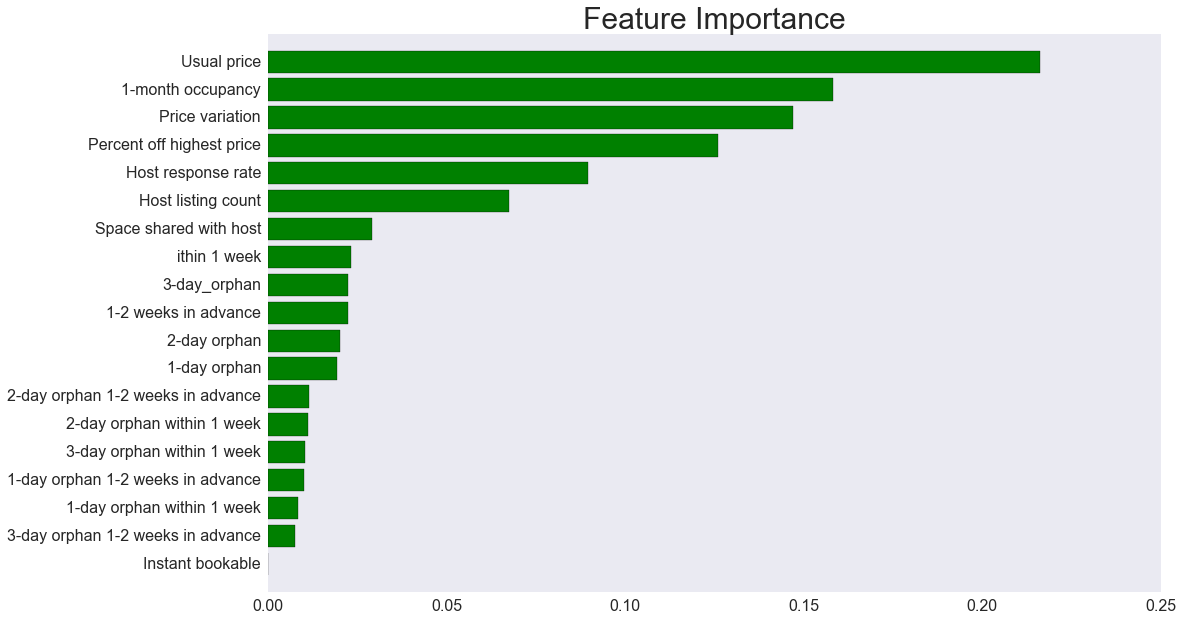

In [273]:
rf = RandomForestClassifier(n_estimators=1000, 
                            max_features=int(np.sqrt(X_willing.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
model_fitting("rf", rf, X_willing_noda, Y_willing)

In [274]:
lr = LogisticRegression()
model_fitting("lr", lr, X_willing_noda, Y_willing)

Average Cross Validation Accuracy: 
0.606685633001
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.57894737  0.73684211  0.59459459  0.56756757
  0.62162162  0.56756757  0.59459459  0.59459459]
Coefficients: 



[('1-day orphan', -0.058816605868184664),
 ('2-day orphan', -0.022026429530236358),
 ('3-day_orphan', 0.40070746223906578),
 ('ithin 1 week', 0.097515398002362044),
 ('1-2 weeks in advance', 0.22496053788570072),
 ('1-day orphan within 1 week', -0.3447817229049106),
 ('1-day orphan 1-2 weeks in advance', 0.54910275351322912),
 ('2-day orphan within 1 week', 0.1798730370351164),
 ('2-day orphan 1-2 weeks in advance', 0.36023068835843464),
 ('3-day orphan within 1 week', -0.59735200540928957),
 ('3-day orphan 1-2 weeks in advance', -0.081993508482559971),
 ('Percent off highest price', -0.30390598119855189),
 ('Host listing count', -0.073482731278795718),
 ('Host response rate', -0.27083788450742963),
 ('Instant bookable', 0.0),
 ('Space shared with host', -0.1289050500607655),
 ('Usual price', 0.003334853642280883),
 ('Price variation', -0.4712212614361766),
 ('1-month occupancy', -0.75552151527434319)]

In [217]:
rf = RandomForestClassifier(n_estimators=1000, 
                            max_features=int(np.sqrt(X_willing.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
rf.fit(X_willing, Y_willing)

rf_scores = -cross_val_score(rf, X_willing, Y_willing, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(rf_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(rf_scores)

Average Cross Validation Accuracy: 
0.56372688478
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.65789474  0.57894737  0.60526316  0.51351351  0.43243243
  0.59459459  0.56756757  0.62162162  0.48648649]


without "discount asked"

In [218]:
rf_noda = RandomForestClassifier(n_estimators=1000, 
                                 max_features=int(np.sqrt(X_willing_noda.shape[1])), 
                                 max_depth=None,
                                 min_samples_split=1)
rf_noda.fit(X_willing_noda, Y_train_willing)

rf_noda_scores = -cross_val_score(rf_noda, X_willing_noda, Y_willing, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(rf_noda_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(rf_noda_scores)

Average Cross Validation Accuracy: 
0.577311522048
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.55263158  0.63157895  0.51351351  0.51351351
  0.59459459  0.56756757  0.64864865  0.54054054]


#### Random Forest: Feature Importance

In scikit-learn, we implement the importance as described in [1]. It is sometimes called "gini importance" or "mean decrease impurity" and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

[1]: Breiman, Friedman, "Classification and regression trees", 1984.

Feature ranking:
1. Instant bookable (feature 14, importance: 0.000000)
2. 3-day orphan 1-2 weeks in advance (feature 10, importance: 0.007759)
3. 1-day orphan within 1 week (feature 5, importance: 0.008550)
4. 1-day orphan 1-2 weeks in advance (feature 6, importance: 0.010001)
5. 3-day orphan within 1 week (feature 9, importance: 0.010538)
6. 2-day orphan 1-2 weeks in advance (feature 8, importance: 0.012010)
7. 2-day orphan within 1 week (feature 7, importance: 0.012027)
8. 1-day orphan (feature 0, importance: 0.017961)
9. 2-day orphan (feature 1, importance: 0.019465)
10. 3-day_orphan (feature 2, importance: 0.021489)
11. 1-2 weeks in advance (feature 4, importance: 0.022089)
12. Within 1 week (feature 3, importance: 0.023788)
13. Space shared with host (feature 15, importance: 0.029119)
14. Host listing count (feature 12, importance: 0.069314)
15. Host response rate (feature 13, importance: 0.090345)
16. Percent off highest price (feature 11, importance: 0.125383)
17. Price variati

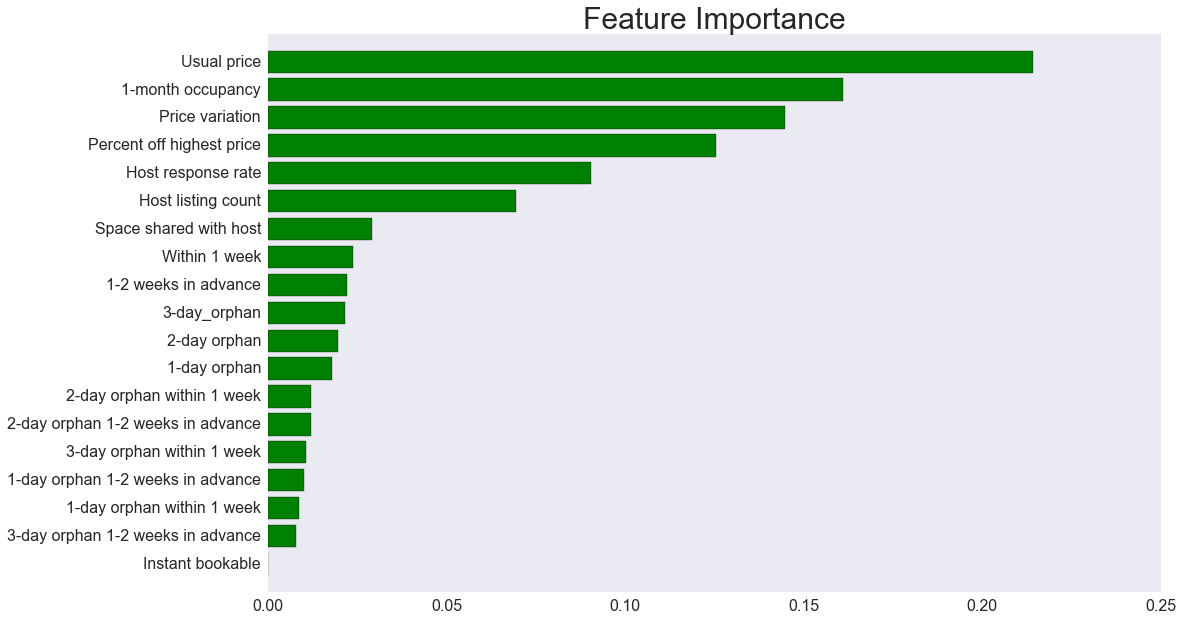

In [250]:
rf_noda_importances = rf_noda.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_noda.estimators_],
             axis=0)
indices = np.argsort(rf_noda_importances)[::1]
param_label_sorted = [param_label_noda[ind] for ind in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_willing_noda.shape[1]):
    print("%d. %s (feature %d, importance: %f)" % (f + 1, param_label[indices[f]], indices[f], rf_noda_importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,10))
plt.title("Feature Importance", fontsize=30)
plt.barh(range(X_willing_noda.shape[1]), rf_noda_importances[indices],
       color="green", align="center")
# plt.axvline(x=0.05, color="red", ls="--")
plt.yticks(range(X_willing_noda.shape[1]), param_label_sorted,  fontsize=16)
plt.xticks(fontsize=16)
plt.ylim([-1, X_willing_noda.shape[1]])
plt.xlim([0,0.25])
plt.grid(False)
plt.show()

Feature ranking:
1. price_median (feature 16, importance: 0.199542)
2. occupancy_1m (feature 18, importance: 0.148174)
3. price_std (feature 17, importance: 0.132372)
4. orig_percent_off (feature 11, importance: 0.113621)
5. response_rate (feature 13, importance: 0.082916)
6. discount_asked (feature 19, importance: 0.069169)
7. host_total_listings_count (feature 12, importance: 0.064280)
8. shared (feature 15, importance: 0.028902)
9. adv_2 (feature 4, importance: 0.021660)
10. adv_1 (feature 3, importance: 0.021522)
11. orp_3 (feature 2, importance: 0.020881)
12. orp_2 (feature 1, importance: 0.019129)
13. orp_1 (feature 0, importance: 0.017725)
14. orp_2, adv_2 (feature 8, importance: 0.012034)
15. orp_2, adv_1 (feature 7, importance: 0.011792)
16. orp_3, adv_1 (feature 9, importance: 0.009991)
17. orp_1, adv_2 (feature 6, importance: 0.009909)
18. orp_1, adv_1 (feature 5, importance: 0.008670)
19. orp_3, adv_2 (feature 10, importance: 0.007709)
20. instant (feature 14, importance: 0

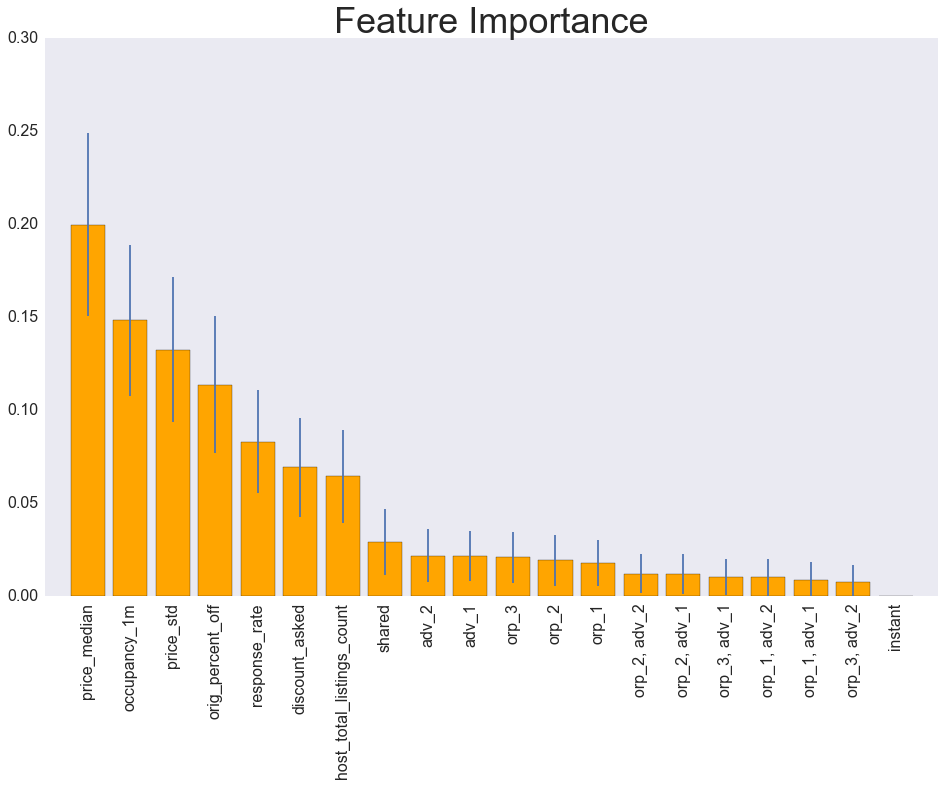

In [251]:
rf_importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(rf_importances)[::-1]
param_sorted = [param[ind] for ind in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_willing.shape[1]):
    print("%d. %s (feature %d, importance: %f)" % (f + 1, param[indices[f]], indices[f], rf_importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,10))
plt.title("Feature Importance", fontsize=36)
plt.bar(range(X_willing.shape[1]), rf_importances[indices],
       color="orange", yerr=std[indices], align="center")
plt.xticks(range(X_willing.shape[1]), param_sorted,  rotation='vertical', fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([-1, X_willing.shape[1]])
plt.ylim([0,0.3])
plt.grid(False)
plt.show()

Feature ranking:
1. price_median (feature 16, importance: 0.214324)
2. occupancy_1m (feature 18, importance: 0.161029)
3. price_std (feature 17, importance: 0.144808)
4. orig_percent_off (feature 11, importance: 0.125383)
5. response_rate (feature 13, importance: 0.090345)
6. host_total_listings_count (feature 12, importance: 0.069314)
7. shared (feature 15, importance: 0.029119)
8. adv_1 (feature 3, importance: 0.023788)
9. adv_2 (feature 4, importance: 0.022089)
10. orp_3 (feature 2, importance: 0.021489)
11. orp_2 (feature 1, importance: 0.019465)
12. orp_1 (feature 0, importance: 0.017961)
13. orp_2, adv_1 (feature 7, importance: 0.012027)
14. orp_2, adv_2 (feature 8, importance: 0.012010)
15. orp_3, adv_1 (feature 9, importance: 0.010538)
16. orp_1, adv_2 (feature 6, importance: 0.010001)
17. orp_1, adv_1 (feature 5, importance: 0.008550)
18. orp_3, adv_2 (feature 10, importance: 0.007759)
19. instant (feature 14, importance: 0.000000)


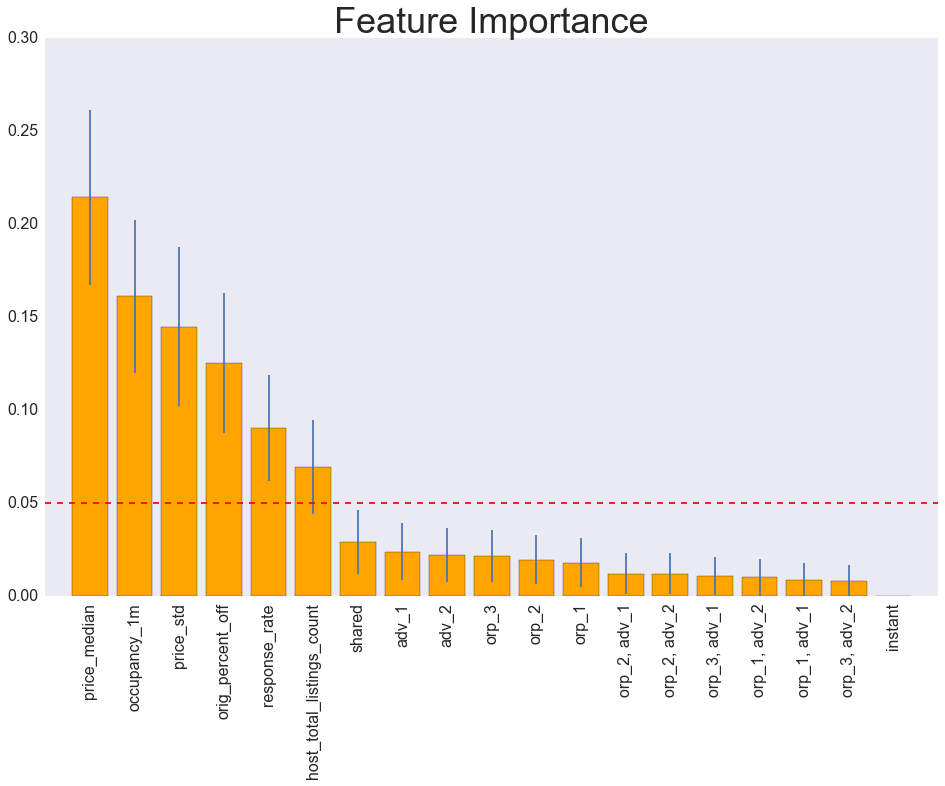

In [240]:
rf_noda_importances = rf_noda.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_noda.estimators_],
             axis=0)
indices = np.argsort(rf_noda_importances)[::-1]
param_sorted = [param_noda[ind] for ind in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_willing_noda.shape[1]):
    print("%d. %s (feature %d, importance: %f)" % (f + 1, param_noda[indices[f]], indices[f], rf_noda_importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,10))
plt.title("Feature Importance", fontsize=36)
plt.bar(range(X_willing_noda.shape[1]), rf_noda_importances[indices],
       color="orange", yerr=std[indices], align="center")
plt.axhline(y=0.05, color="red", ls="--")
plt.xticks(range(X_willing_noda.shape[1]), param_sorted,  rotation='vertical', fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([-1, X_willing_noda.shape[1]])
plt.ylim([0,0.3])
plt.grid(False)
plt.show()

#### Extremely Randomized Trees (Extra Trees)

In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

Extra Trees is an emsemble method similar to Random Forest, with the following differences:

1. When choosing variables at a split, samples are drawn from the entire training set instead of a bootstrap sample of the training set.
2. Splits are chosen completely at random from the range of values in the sample at each split.

Reference: P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3-42, 2006

In [147]:
extra_trees = ExtraTreesClassifier(n_estimators=250, max_depth=X_train_willing.shape[1])
extra_trees.fit(X_train_willing, Y_train_willing)

extra_trees_scores = -cross_val_score(extra_trees, X_train_willing, Y_train_willing, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(extra_trees_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(extra_trees_scores)

Average Cross Validation Accuracy: 
0.539829302987
Cross Validation Accuracies by Fold: 
[ 0.52631579  0.63157895  0.55263158  0.55263158  0.51351351  0.51351351
  0.51351351  0.48648649  0.59459459  0.51351351]


In [201]:
extra_trees_no_da = ExtraTreesClassifier(n_estimators=250, max_depth=X_train_willing_no_da.shape[1])
extra_trees_no_da.fit(X_train_willing_no_da, Y_train_willing)

extra_trees_no_da_scores = -cross_val_score(extra_trees_no_da, X_train_willing_no_da, Y_train_willing, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(extra_trees_no_da_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(extra_trees_no_da_scores)

Average Cross Validation Accuracy: 
0.577240398293
Cross Validation Accuracies by Fold: 
[ 0.60526316  0.55263158  0.60526316  0.65789474  0.59459459  0.54054054
  0.56756757  0.54054054  0.59459459  0.51351351]


Feature ranking:
1. price_median (feature 16, importance: 0.157346)
2. occupancy_1m (feature 18, importance: 0.136581)
3. price_std (feature 17, importance: 0.123481)
4. orig_percent_off (feature 11, importance: 0.106746)
5. response_rate (feature 13, importance: 0.095888)
6. discount_asked (feature 19, importance: 0.093922)
7. host_total_listings_count (feature 12, importance: 0.089679)
8. shared (feature 15, importance: 0.039941)
9. adv_1 (feature 3, importance: 0.020939)
10. adv_2 (feature 4, importance: 0.020717)
11. orp_2 (feature 1, importance: 0.020612)
12. orp_3 (feature 2, importance: 0.020361)
13. orp_1 (feature 0, importance: 0.019696)
14. orp_2, adv_1 (feature 7, importance: 0.011206)
15. orp_2, adv_2 (feature 8, importance: 0.010804)
16. orp_3, adv_1 (feature 9, importance: 0.008688)
17. orp_1, adv_2 (feature 6, importance: 0.008538)
18. orp_1, adv_1 (feature 5, importance: 0.008023)
19. orp_3, adv_2 (feature 10, importance: 0.006831)
20. instant (feature 14, importance: 0

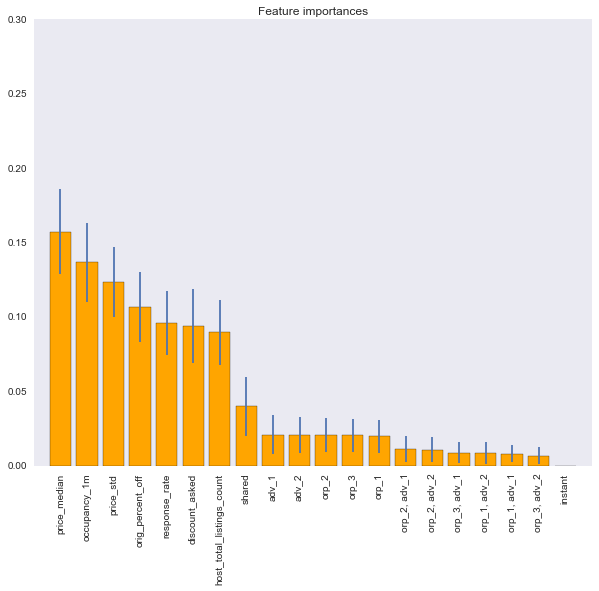

In [178]:
importances = extra_trees.feature_importances_
std = np.std([tree.feature_importances_ for tree in extra_trees.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
param_sorted = [param[ind] for ind in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_willing.shape[1]):
    print("%d. %s (feature %d, importance: %f)" % (f + 1, param[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,8))
plt.title("Feature importances")
plt.bar(range(X_train_willing.shape[1]), importances[indices],
       color="orange", yerr=std[indices], align="center")
plt.xticks(range(X_train_willing.shape[1]), param_sorted,  rotation='vertical')
plt.xlim([-1, X_train_willing.shape[1]])
plt.ylim([0,0.3])
plt.grid(False)
plt.show()

#### Logistic

In [255]:
lr_noda = LogisticRegression()
lr_noda.fit(X_willing_noda, Y_willing)

lr_noda_scores = -cross_val_score(lr, X_willing_noda, Y_willing, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(lr_noda_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(lr_noda_scores)
print "Coefficients: \n"
zip(param_label_noda, np.ravel(lr_noda.coef_))

# print "Predictions: \n", lr.predict(X_train_willing)

Average Cross Validation Accuracy: 
0.606685633001
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.57894737  0.73684211  0.59459459  0.56756757
  0.62162162  0.56756757  0.59459459  0.59459459]
Coefficients: 



[('1-day orphan', -0.058816605868184664),
 ('2-day orphan', -0.022026429530236358),
 ('3-day_orphan', 0.40070746223906578),
 ('Within 1 week', 0.097515398002362044),
 ('1-2 weeks in advance', 0.22496053788570072),
 ('1-day orphan within 1 week', -0.3447817229049106),
 ('1-day orphan 1-2 weeks in advance', 0.54910275351322912),
 ('2-day orphan within 1 week', 0.1798730370351164),
 ('2-day orphan 1-2 weeks in advance', 0.36023068835843464),
 ('3-day orphan within 1 week', -0.59735200540928957),
 ('3-day orphan 1-2 weeks in advance', -0.081993508482559971),
 ('Percent off highest price', -0.30390598119855189),
 ('Host listing count', -0.073482731278795718),
 ('Host response rate', -0.27083788450742963),
 ('Instant bookable', 0.0),
 ('Space shared with host', -0.1289050500607655),
 ('Usual price', 0.003334853642280883),
 ('Price variation', -0.4712212614361766),
 ('1-month occupancy', -0.75552151527434319)]

In [254]:
lr = LogisticRegression()
lr.fit(X_willing, Y_willing)

lr_scores = -cross_val_score(lr, X_willing, Y_willing, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(lr_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(lr_scores)
print "Coefficients: \n"
zip(param, np.ravel(lr.coef_))

# print "Predictions: \n", lr.predict(X_train_willing)

Average Cross Validation Accuracy: 
0.606685633001
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.57894737  0.73684211  0.59459459  0.56756757
  0.59459459  0.56756757  0.62162162  0.59459459]
Coefficients: 



[('orp_1', -0.070869195314944525),
 ('orp_2', -0.026553168359222761),
 ('orp_3', 0.39780540860923969),
 ('adv_1', 0.0851825905656204),
 ('adv_2', 0.22139010194936498),
 ('orp_1, adv_1', -0.32879726663631303),
 ('orp_1, adv_2', 0.55018149583809683),
 ('orp_2, adv_1', 0.18103653206945122),
 ('orp_2, adv_2', 0.35946492356044463),
 ('orp_3, adv_1', -0.59084337512567542),
 ('orp_3, adv_2', -0.08773467851911057),
 ('orig_percent_off', -0.30345614725671732),
 ('host_total_listings_count', -0.073373319250669464),
 ('response_rate', -0.33331873110532373),
 ('instant', 0.0),
 ('shared', -0.13924598843371078),
 ('price_median', 0.0032488150186881551),
 ('price_std', -0.47318658920911771),
 ('occupancy_1m', -0.74782602169023171),
 ('discount_asked', 0.27626175457612945)]

## SVM

In [134]:
svm = svm.SVC()
svm.fit(X_willing_noda, Y_willing)  

clf_scores = -cross_val_score(clf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [135]:
clf.score(X_train, Y_train)

0.82692307692307687

In [136]:
clf_scores

array([ 0.45454545,  0.36363636,  0.4       ,  0.25      ,  0.35      ])

In [137]:
clf.support_vectors_

array([[   1.,    0.,    0., ...,   65.,    1.,    0.],
       [   1.,    0.,    0., ...,   32.,    1.,    0.],
       [   1.,    0.,    0., ...,   48.,    1.,    0.],
       ..., 
       [   0.,    0.,    0., ...,  283.,    0.,    0.],
       [   0.,    0.,    0., ...,   69.,    1.,    0.],
       [   0.,    0.,    0., ...,   72.,    1.,    0.]])